# Convolutional Neural Network to Classify Images
We use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) database to train a CNN.

## 1. Load Dataset

In [1]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


In [2]:
print('images:', x_train.shape[1:])
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

from collections import Counter
import numpy as np

#print Counter(list(np.vstack([y_train,y_test])[:,0])).items()
for key, val in Counter(list(np.vstack([y_train,y_test]).squeeze())).items():
    print("label: %d, size: %d" %(key, val))

images: (32, 32, 3)
50000 train samples
10000 test samples
label: 0, size: 6000
label: 1, size: 6000
label: 2, size: 6000
label: 3, size: 6000
label: 4, size: 6000
label: 5, size: 6000
label: 6, size: 6000
label: 7, size: 6000
label: 8, size: 6000
label: 9, size: 6000


The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

## 2. Visualization

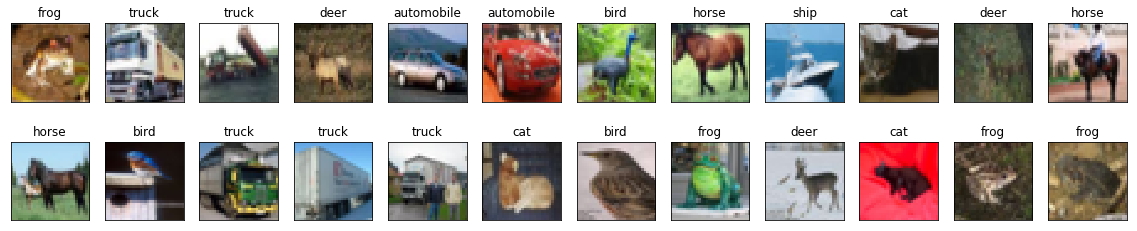

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

label ={'0':'airplane', '1':'automobile', '2':'bird', '3':'cat', '4':'deer', 
        '5':'dog', '6':'frog', '7':'horse', '8':'ship', '9':'truck'}

fig = plt.figure(figsize = (20,4) )
for i in range(24):
    ax = fig.add_subplot(2, 12, i+1, xticks = [], yticks = [])
    ax.imshow(x_train[i])
    ax.set_title(label["".join(map(str,y_train[i]))])    

## 3. Pre-processing
### A. Rescaling
We first rescale the images by dividing every pixel in every image by 255.

In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

### B. One-hot Encoding
We convert class vectors to binary class matrices.

In [5]:
from keras.utils import to_categorical

y_train = np.squeeze(to_categorical(y_train, num_classes=10))
y_test = np.squeeze(to_categorical(y_test, num_classes=10))

### C. Validation Set
We create a validation set by breaking the training set into two sets

In [6]:
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_valid.shape[0], 'validation samples')

45000 train samples
10000 test samples
5000 validation samples


## 4. CNN
### A. Architecture

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
__________

## B. Compilation

In [8]:
from keras.optimizers import rmsprop

opt = rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## C. Fit

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, History

checkpointer = ModelCheckpoint(filepath = 'cifar10.best.hdf5', verbose = 1, save_best_only = True)
checkimprovement = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)
history = History()

model.fit(x_train, y_train, batch_size = 32, epochs = 100, validation_data = (x_valid,y_valid),
          callbacks = [checkpointer,checkimprovement,history], verbose = 1, shuffle = True)